## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3,0.5,0.7]
redice_lr_patient = [3,5,7]

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 2s 46us/step - loss: 0.8880 - acc: 0.7112 - val_loss: 1.4447 - val_acc: 0.5086

Epoch 00044: ReduceLROnPlateau reducing learning rate to 2.1870000637136398e-07.
Epoch 45/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.8876 - acc: 0.7108 - val_loss: 1.4447 - val_acc: 0.5086
Epoch 46/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.8883 - acc: 0.7089 - val_loss: 1.4447 - val_acc: 0.5084
Epoch 47/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.8878 - acc: 0.7102 - val_loss: 1.4447 - val_acc: 0.5084

Epoch 00047: ReduceLROnPlateau reducing learning rate to 6.561000276406048e-08.
Epoch 48/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.8882 - acc: 0.7102 - val_loss: 1.4446 - val_acc: 0.5085
Epoch 49/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.8887 - acc: 0.7093 - val_loss: 1.4447 - val_acc: 0.5084
Epoch 50/50
50000/500

Epoch 41/50
50000/50000 [==============================] - 2s 41us/step - loss: 3.1735 - acc: 0.0704 - val_loss: 3.1769 - val_acc: 0.0748
Epoch 42/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.1729 - acc: 0.0707 - val_loss: 3.1766 - val_acc: 0.0747
Epoch 43/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.1735 - acc: 0.0710 - val_loss: 3.1764 - val_acc: 0.0746
Epoch 44/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.1722 - acc: 0.0710 - val_loss: 3.1759 - val_acc: 0.0747
Epoch 45/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.1708 - acc: 0.0714 - val_loss: 3.1754 - val_acc: 0.0749
Epoch 46/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.1706 - acc: 0.0710 - val_loss: 3.1751 - val_acc: 0.0751
Epoch 47/50
50000/50000 [==============================] - 3s 51us/step - loss: 3.1707 - acc: 0.0705 - val_loss: 3.1748 - val_acc: 0.0752
Epoch 48/50
50000/50000 [=========

50000/50000 [==============================] - 2s 44us/step - loss: 3.1170 - acc: 0.0920 - val_loss: 3.1340 - val_acc: 0.0909
Epoch 40/50
50000/50000 [==============================] - 2s 48us/step - loss: 3.1164 - acc: 0.0923 - val_loss: 3.1338 - val_acc: 0.0909
Epoch 41/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.1153 - acc: 0.0925 - val_loss: 3.1334 - val_acc: 0.0910
Epoch 42/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.1154 - acc: 0.0928 - val_loss: 3.1331 - val_acc: 0.0910
Epoch 43/50
50000/50000 [==============================] - 2s 49us/step - loss: 3.1146 - acc: 0.0933 - val_loss: 3.1325 - val_acc: 0.0910
Epoch 44/50
50000/50000 [==============================] - 2s 48us/step - loss: 3.1145 - acc: 0.0931 - val_loss: 3.1321 - val_acc: 0.0910
Epoch 45/50
50000/50000 [==============================] - 2s 48us/step - loss: 3.1138 - acc: 0.0923 - val_loss: 3.1316 - val_acc: 0.0911
Epoch 46/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 41us/step - loss: 3.0811 - acc: 0.1003 - val_loss: 3.0814 - val_acc: 0.1027
Epoch 38/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.0813 - acc: 0.1009 - val_loss: 3.0809 - val_acc: 0.1031
Epoch 39/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.0804 - acc: 0.1003 - val_loss: 3.0808 - val_acc: 0.1030
Epoch 40/50
50000/50000 [==============================] - 2s 41us/step - loss: 3.0804 - acc: 0.1005 - val_loss: 3.0804 - val_acc: 0.1031
Epoch 41/50
50000/50000 [==============================] - 2s 41us/step - loss: 3.0794 - acc: 0.1006 - val_loss: 3.0799 - val_acc: 0.1031
Epoch 42/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.0795 - acc: 0.1007 - val_loss: 3.0795 - val_acc: 0.1031
Epoch 43/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.0784 - acc: 0.1008 - val_loss: 3.0791 - val_acc: 0.1031
Epoch 44/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 41us/step - loss: 3.1157 - acc: 0.0960 - val_loss: 3.1331 - val_acc: 0.0946
Epoch 36/50
50000/50000 [==============================] - 2s 41us/step - loss: 3.1154 - acc: 0.0957 - val_loss: 3.1328 - val_acc: 0.0949
Epoch 37/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.1149 - acc: 0.0969 - val_loss: 3.1325 - val_acc: 0.0948
Epoch 38/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.1136 - acc: 0.0958 - val_loss: 3.1322 - val_acc: 0.0948
Epoch 39/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.1148 - acc: 0.0968 - val_loss: 3.1316 - val_acc: 0.0947
Epoch 40/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.1130 - acc: 0.0968 - val_loss: 3.1314 - val_acc: 0.0949
Epoch 41/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.1135 - acc: 0.0969 - val_loss: 3.1309 - val_acc: 0.0949
Epoch 42/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 48us/step - loss: 3.0947 - acc: 0.0922 - val_loss: 3.0809 - val_acc: 0.0928
Epoch 34/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.0945 - acc: 0.0928 - val_loss: 3.0804 - val_acc: 0.0928
Epoch 35/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0938 - acc: 0.0932 - val_loss: 3.0800 - val_acc: 0.0929
Epoch 36/50
50000/50000 [==============================] - 2s 47us/step - loss: 3.0946 - acc: 0.0934 - val_loss: 3.0795 - val_acc: 0.0928
Epoch 37/50
50000/50000 [==============================] - 2s 50us/step - loss: 3.0927 - acc: 0.0937 - val_loss: 3.0791 - val_acc: 0.0928
Epoch 38/50
50000/50000 [==============================] - 2s 42us/step - loss: 3.0924 - acc: 0.0940 - val_loss: 3.0787 - val_acc: 0.0930
Epoch 39/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0914 - acc: 0.0934 - val_loss: 3.0783 - val_acc: 0.0930
Epoch 40/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 42us/step - loss: 2.9724 - acc: 0.1102 - val_loss: 2.9620 - val_acc: 0.1101
Epoch 32/50
50000/50000 [==============================] - 2s 42us/step - loss: 2.9729 - acc: 0.1099 - val_loss: 2.9619 - val_acc: 0.1103
Epoch 33/50
50000/50000 [==============================] - 2s 42us/step - loss: 2.9728 - acc: 0.1095 - val_loss: 2.9615 - val_acc: 0.1101
Epoch 34/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.9708 - acc: 0.1101 - val_loss: 2.9613 - val_acc: 0.1102
Epoch 35/50
50000/50000 [==============================] - 3s 50us/step - loss: 2.9710 - acc: 0.1098 - val_loss: 2.9609 - val_acc: 0.1104
Epoch 36/50
50000/50000 [==============================] - 2s 43us/step - loss: 2.9710 - acc: 0.1095 - val_loss: 2.9606 - val_acc: 0.1100
Epoch 37/50
50000/50000 [==============================] - 2s 42us/step - loss: 2.9713 - acc: 0.1096 - val_loss: 2.9605 - val_acc: 0.1103
Epoch 38/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 42us/step - loss: 2.9745 - acc: 0.1194 - val_loss: 2.9784 - val_acc: 0.1165
Epoch 30/50
50000/50000 [==============================] - 2s 42us/step - loss: 2.9751 - acc: 0.1184 - val_loss: 2.9783 - val_acc: 0.1165
Epoch 31/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.9745 - acc: 0.1194 - val_loss: 2.9781 - val_acc: 0.1166
Epoch 32/50
50000/50000 [==============================] - 2s 43us/step - loss: 2.9761 - acc: 0.1176 - val_loss: 2.9775 - val_acc: 0.1167
Epoch 33/50
50000/50000 [==============================] - 2s 44us/step - loss: 2.9738 - acc: 0.1182 - val_loss: 2.9773 - val_acc: 0.1168
Epoch 34/50
50000/50000 [==============================] - 2s 43us/step - loss: 2.9723 - acc: 0.1188 - val_loss: 2.9769 - val_acc: 0.1168
Epoch 35/50
50000/50000 [==============================] - 2s 42us/step - loss: 2.9725 - acc: 0.1190 - val_loss: 2.9765 - val_acc: 0.1167
Epoch 36/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 42us/step - loss: 3.0424 - acc: 0.1106 - val_loss: 3.0348 - val_acc: 0.1134
Epoch 28/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0433 - acc: 0.1097 - val_loss: 3.0345 - val_acc: 0.1133
Epoch 29/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0428 - acc: 0.1107 - val_loss: 3.0343 - val_acc: 0.1132
Epoch 30/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0420 - acc: 0.1106 - val_loss: 3.0340 - val_acc: 0.1135
Epoch 31/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0403 - acc: 0.1103 - val_loss: 3.0334 - val_acc: 0.1135
Epoch 32/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0414 - acc: 0.1106 - val_loss: 3.0333 - val_acc: 0.1135
Epoch 33/50
50000/50000 [==============================] - 2s 48us/step - loss: 3.0409 - acc: 0.1097 - val_loss: 3.0330 - val_acc: 0.1136
Epoch 34/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 43us/step - loss: 0.7192 - acc: 0.7673 - val_loss: 1.3539 - val_acc: 0.5380
Epoch 24/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7173 - acc: 0.7693 - val_loss: 1.3532 - val_acc: 0.5394

Epoch 00024: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
Epoch 25/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7153 - acc: 0.7704 - val_loss: 1.3540 - val_acc: 0.5405
Epoch 26/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7144 - acc: 0.7702 - val_loss: 1.3546 - val_acc: 0.5385
Epoch 27/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7138 - acc: 0.7708 - val_loss: 1.3554 - val_acc: 0.5387

Epoch 00027: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
Epoch 28/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7126 - acc: 0.7706 - val_loss: 1.3556 - val_acc: 0.5389
Epoch 29/50
50000/5000

50000/50000 [==============================] - 2s 43us/step - loss: 3.0554 - acc: 0.0942 - val_loss: 3.0624 - val_acc: 0.0935
Epoch 16/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0583 - acc: 0.0944 - val_loss: 3.0621 - val_acc: 0.0935
Epoch 17/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0562 - acc: 0.0953 - val_loss: 3.0622 - val_acc: 0.0934
Epoch 18/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0567 - acc: 0.0948 - val_loss: 3.0621 - val_acc: 0.0934
Epoch 19/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0580 - acc: 0.0951 - val_loss: 3.0622 - val_acc: 0.0934

Epoch 00019: ReduceLROnPlateau reducing learning rate to 4.304672243660157e-12.
Epoch 20/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0560 - acc: 0.0948 - val_loss: 3.0622 - val_acc: 0.0934
Epoch 21/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0573 - acc: 0.0942 - 

Epoch 12/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0292 - acc: 0.0922 - val_loss: 3.0224 - val_acc: 0.0923
Epoch 13/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0296 - acc: 0.0918 - val_loss: 3.0221 - val_acc: 0.0920
Epoch 14/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0298 - acc: 0.0922 - val_loss: 3.0221 - val_acc: 0.0919
Epoch 15/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0294 - acc: 0.0914 - val_loss: 3.0220 - val_acc: 0.0920
Epoch 16/50
50000/50000 [==============================] - 2s 46us/step - loss: 3.0280 - acc: 0.0910 - val_loss: 3.0219 - val_acc: 0.0922
Epoch 17/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0287 - acc: 0.0927 - val_loss: 3.0219 - val_acc: 0.0920
Epoch 18/50
50000/50000 [==============================] - 2s 46us/step - loss: 3.0291 - acc: 0.0924 - val_loss: 3.0219 - val_acc: 0.0921
Epoch 19/50
50000/50000 [=========

50000/50000 [==============================] - 2s 44us/step - loss: 3.0640 - acc: 0.1015 - val_loss: 3.0514 - val_acc: 0.1014
Epoch 11/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0638 - acc: 0.1022 - val_loss: 3.0518 - val_acc: 0.1013
Epoch 12/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0643 - acc: 0.1013 - val_loss: 3.0517 - val_acc: 0.1014
Epoch 13/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0640 - acc: 0.1019 - val_loss: 3.0514 - val_acc: 0.1013
Epoch 14/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0641 - acc: 0.1018 - val_loss: 3.0516 - val_acc: 0.1012
Epoch 15/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0642 - acc: 0.1013 - val_loss: 3.0517 - val_acc: 0.1013
Epoch 16/50
50000/50000 [==============================] - 2s 46us/step - loss: 3.0631 - acc: 0.1018 - val_loss: 3.0516 - val_acc: 0.1014
Epoch 17/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 43us/step - loss: 3.0364 - acc: 0.0939 - val_loss: 3.0269 - val_acc: 0.1003
Epoch 9/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0363 - acc: 0.0944 - val_loss: 3.0265 - val_acc: 0.1004
Epoch 10/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0360 - acc: 0.0951 - val_loss: 3.0268 - val_acc: 0.1004
Epoch 11/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0355 - acc: 0.0946 - val_loss: 3.0268 - val_acc: 0.1004
Epoch 12/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0362 - acc: 0.0958 - val_loss: 3.0270 - val_acc: 0.1005
Epoch 13/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0356 - acc: 0.0956 - val_loss: 3.0270 - val_acc: 0.1004
Epoch 14/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0362 - acc: 0.0951 - val_loss: 3.0270 - val_acc: 0.1003
Epoch 15/50
50000/50000 [======================

50000/50000 [==============================] - 2s 44us/step - loss: 3.1940 - acc: 0.0772 - val_loss: 3.1837 - val_acc: 0.0777
Epoch 7/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.1933 - acc: 0.0768 - val_loss: 3.1837 - val_acc: 0.0778
Epoch 8/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.1940 - acc: 0.0764 - val_loss: 3.1837 - val_acc: 0.0779
Epoch 9/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.1936 - acc: 0.0760 - val_loss: 3.1835 - val_acc: 0.0778
Epoch 10/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.1932 - acc: 0.0759 - val_loss: 3.1835 - val_acc: 0.0779
Epoch 11/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.1941 - acc: 0.0759 - val_loss: 3.1835 - val_acc: 0.0779
Epoch 12/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.1936 - acc: 0.0759 - val_loss: 3.1834 - val_acc: 0.0777
Epoch 13/50
50000/50000 [========================

50000/50000 [==============================] - 2s 44us/step - loss: 3.0895 - acc: 0.0910 - val_loss: 3.0817 - val_acc: 0.0905
Epoch 5/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0903 - acc: 0.0906 - val_loss: 3.0818 - val_acc: 0.0906
Epoch 6/50
50000/50000 [==============================] - 3s 52us/step - loss: 3.0903 - acc: 0.0909 - val_loss: 3.0818 - val_acc: 0.0905
Epoch 7/50
50000/50000 [==============================] - 2s 47us/step - loss: 3.0889 - acc: 0.0901 - val_loss: 3.0820 - val_acc: 0.0905
Epoch 8/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0895 - acc: 0.0911 - val_loss: 3.0822 - val_acc: 0.0904
Epoch 9/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0904 - acc: 0.0915 - val_loss: 3.0821 - val_acc: 0.0904
Epoch 10/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0906 - acc: 0.0907 - val_loss: 3.0819 - val_acc: 0.0904
Epoch 11/50
50000/50000 [==========================

50000/50000 [==============================] - 2s 44us/step - loss: 2.9644 - acc: 0.0995 - val_loss: 2.9710 - val_acc: 0.0988
Epoch 3/50
50000/50000 [==============================] - 2s 44us/step - loss: 2.9648 - acc: 0.0998 - val_loss: 2.9711 - val_acc: 0.0987
Epoch 4/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.9640 - acc: 0.1002 - val_loss: 2.9711 - val_acc: 0.0986
Epoch 5/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.9629 - acc: 0.1002 - val_loss: 2.9713 - val_acc: 0.0987
Epoch 6/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.9642 - acc: 0.0994 - val_loss: 2.9714 - val_acc: 0.0988
Epoch 7/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.9644 - acc: 0.0997 - val_loss: 2.9713 - val_acc: 0.0986
Epoch 8/50
50000/50000 [==============================] - 3s 51us/step - loss: 2.9636 - acc: 0.0991 - val_loss: 2.9712 - val_acc: 0.0988
Epoch 9/50
50000/50000 [============================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 105us/step - loss: 2.9397 - acc: 0.1087 - val_loss: 2.9476 - val_acc: 0.1082
Epoch 2/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.9403 - acc: 0.1094 - val_loss: 2.9476 - val_acc: 0.1079
Epoch 3/50
50000/50000 [==============================] - 2s 47us/step - loss: 2.9407 - acc: 0.1088 - val_loss: 2.9475 - val_acc: 0.1081
Epoch 4/50
50000/50000 [==============================] - 2s 48us/step - loss: 2.9395 - acc: 0.1091 - val_loss: 2.9476 - val_acc: 0.1080
Epoch 5/50
50000/50000 [==============================] - 2s 49us/step - loss: 2.9396 - acc: 0.1092 - val_loss: 2.9476 - val_acc: 0.1081
Epoch 6/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.9401 - acc: 0.1104 - val_loss: 2.9475 - val_acc: 0.1080
Epoch 7/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.9401 - acc: 0.1083 - val_loss: 2.9478 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.7887 - acc: 0.3787 - val_loss: 2.9248 - val_acc: 0.2334
Epoch 2/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.5266 - acc: 0.4590 - val_loss: 2.1288 - val_acc: 0.3156
Epoch 3/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.4229 - acc: 0.4990 - val_loss: 2.1632 - val_acc: 0.3077
Epoch 4/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.3506 - acc: 0.5233 - val_loss: 2.0170 - val_acc: 0.3272
Epoch 5/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2922 - acc: 0.5441 - val_loss: 2.3544 - val_acc: 0.3107
Epoch 6/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2421 - acc: 0.5602 - val_loss: 1.8359 - val_acc: 0.3559
Epoch 7/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.1982 - acc: 0.5798 - val_loss: 1.7792 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 107us/step - loss: 3.1511 - acc: 0.0969 - val_loss: 3.1635 - val_acc: 0.1017
Epoch 2/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.1508 - acc: 0.0973 - val_loss: 3.1639 - val_acc: 0.1015
Epoch 3/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.1522 - acc: 0.0977 - val_loss: 3.1632 - val_acc: 0.1017
Epoch 4/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.1524 - acc: 0.0970 - val_loss: 3.1634 - val_acc: 0.1016
Epoch 5/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.1510 - acc: 0.0967 - val_loss: 3.1633 - val_acc: 0.1018
Epoch 6/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.1510 - acc: 0.0978 - val_loss: 3.1632 - val_acc: 0.1017
Epoch 7/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.1509 - acc: 0.0973 - val_loss: 3.1633 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 112us/step - loss: 3.0940 - acc: 0.0956 - val_loss: 3.0939 - val_acc: 0.0951
Epoch 2/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0940 - acc: 0.0955 - val_loss: 3.0943 - val_acc: 0.0951
Epoch 3/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0942 - acc: 0.0956 - val_loss: 3.0938 - val_acc: 0.0949
Epoch 4/50
50000/50000 [==============================] - 2s 47us/step - loss: 3.0928 - acc: 0.0957 - val_loss: 3.0937 - val_acc: 0.0949
Epoch 5/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0938 - acc: 0.0953 - val_loss: 3.0938 - val_acc: 0.0949
Epoch 6/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0943 - acc: 0.0952 - val_loss: 3.0939 - val_acc: 0.0950
Epoch 7/50
50000/50000 [==============================] - 2s 47us/step - loss: 3.0942 - acc: 0.0952 - val_loss: 3.0939 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 115us/step - loss: 3.2259 - acc: 0.0763 - val_loss: 3.2158 - val_acc: 0.0747
Epoch 2/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.2279 - acc: 0.0754 - val_loss: 3.2160 - val_acc: 0.0748
Epoch 3/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.2264 - acc: 0.0762 - val_loss: 3.2163 - val_acc: 0.0749
Epoch 4/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.2271 - acc: 0.0749 - val_loss: 3.2162 - val_acc: 0.0750
Epoch 5/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.2268 - acc: 0.0759 - val_loss: 3.2163 - val_acc: 0.0750
Epoch 6/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.2272 - acc: 0.0754 - val_loss: 3.2161 - val_acc: 0.0750
Epoch 7/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.2265 - acc: 0.0756 - val_loss: 3.2162 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 117us/step - loss: 3.0907 - acc: 0.0924 - val_loss: 3.0971 - val_acc: 0.0925
Epoch 2/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0905 - acc: 0.0937 - val_loss: 3.0974 - val_acc: 0.0925
Epoch 3/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0894 - acc: 0.0931 - val_loss: 3.0972 - val_acc: 0.0923
Epoch 4/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0900 - acc: 0.0933 - val_loss: 3.0971 - val_acc: 0.0925
Epoch 5/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0894 - acc: 0.0923 - val_loss: 3.0971 - val_acc: 0.0927
Epoch 6/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0894 - acc: 0.0930 - val_loss: 3.0972 - val_acc: 0.0926
Epoch 7/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0906 - acc: 0.0925 - val_loss: 3.0972 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 123us/step - loss: 3.0499 - acc: 0.1039 - val_loss: 3.0454 - val_acc: 0.1069
Epoch 2/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0500 - acc: 0.1038 - val_loss: 3.0449 - val_acc: 0.1064
Epoch 3/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0499 - acc: 0.1046 - val_loss: 3.0445 - val_acc: 0.1065
Epoch 4/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0496 - acc: 0.1041 - val_loss: 3.0446 - val_acc: 0.1065
Epoch 5/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0492 - acc: 0.1044 - val_loss: 3.0448 - val_acc: 0.1064
Epoch 6/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0499 - acc: 0.1052 - val_loss: 3.0448 - val_acc: 0.1063
Epoch 7/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0495 - acc: 0.1038 - val_loss: 3.0448 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 123us/step - loss: 3.0732 - acc: 0.0961 - val_loss: 3.0657 - val_acc: 0.1016
Epoch 2/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0723 - acc: 0.0961 - val_loss: 3.0658 - val_acc: 0.1016
Epoch 3/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0729 - acc: 0.0952 - val_loss: 3.0659 - val_acc: 0.1015
Epoch 4/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0718 - acc: 0.0964 - val_loss: 3.0657 - val_acc: 0.1014
Epoch 5/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0721 - acc: 0.0962 - val_loss: 3.0657 - val_acc: 0.1013
Epoch 6/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0718 - acc: 0.0958 - val_loss: 3.0658 - val_acc: 0.1014
Epoch 7/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0716 - acc: 0.0956 - val_loss: 3.0658 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 126us/step - loss: 3.0155 - acc: 0.1020 - val_loss: 3.0095 - val_acc: 0.1038
Epoch 2/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0150 - acc: 0.1028 - val_loss: 3.0093 - val_acc: 0.1038
Epoch 3/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0166 - acc: 0.1023 - val_loss: 3.0092 - val_acc: 0.1038
Epoch 4/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0171 - acc: 0.1024 - val_loss: 3.0091 - val_acc: 0.1036
Epoch 5/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0146 - acc: 0.1024 - val_loss: 3.0092 - val_acc: 0.1036
Epoch 6/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0153 - acc: 0.1019 - val_loss: 3.0090 - val_acc: 0.1037
Epoch 7/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0153 - acc: 0.1021 - val_loss: 3.0092 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 130us/step - loss: 3.0565 - acc: 0.0904 - val_loss: 3.0705 - val_acc: 0.0881
Epoch 2/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0561 - acc: 0.0908 - val_loss: 3.0706 - val_acc: 0.0882
Epoch 3/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0559 - acc: 0.0917 - val_loss: 3.0707 - val_acc: 0.0884
Epoch 4/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0561 - acc: 0.0914 - val_loss: 3.0702 - val_acc: 0.0881
Epoch 5/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0573 - acc: 0.0902 - val_loss: 3.0705 - val_acc: 0.0883
Epoch 6/50
50000/50000 [==============================] - 2s 45us/step - loss: 3.0566 - acc: 0.0922 - val_loss: 3.0705 - val_acc: 0.0884
Epoch 7/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0564 - acc: 0.0903 - val_loss: 3.0702 - val_ac

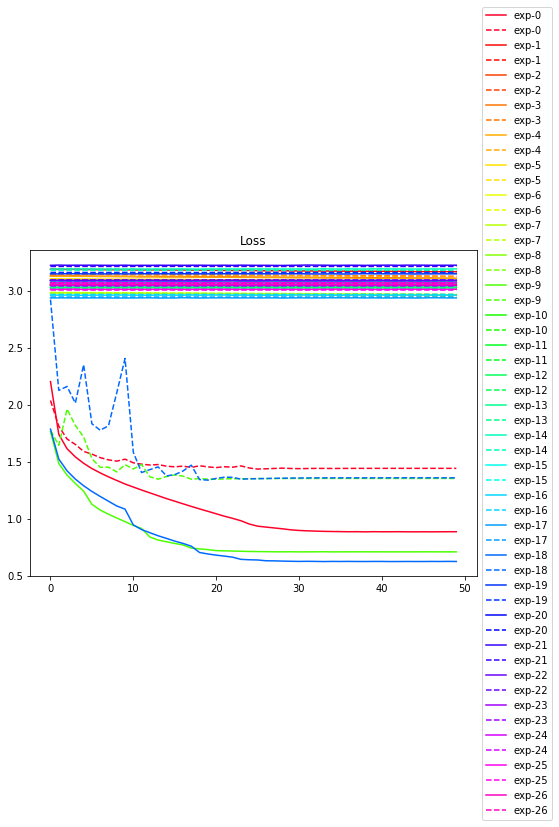

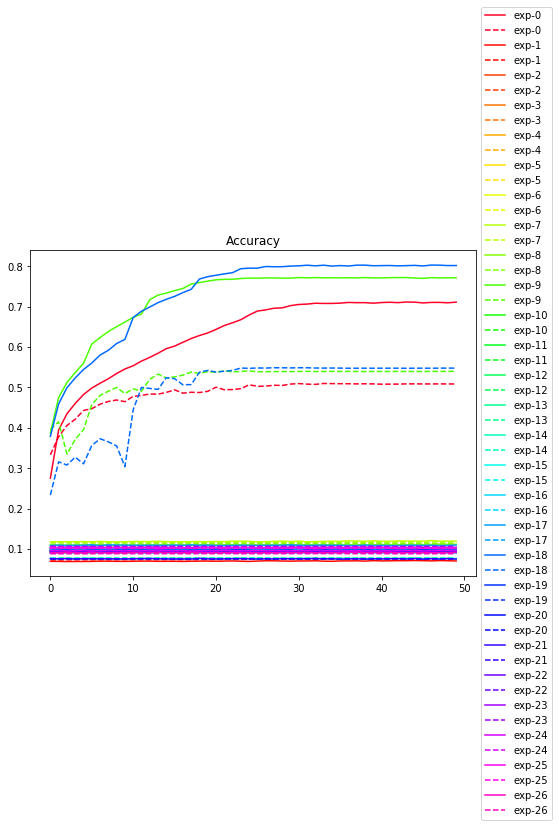

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()